/tmp/ipykernel_3859784/505812993.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(weight_path, map_location="cpu")


odict_keys(['W_enc', 'W_dec', 'b_enc', 'b_dec'])
torch.Size([32768, 5120]) torch.Size([32768, 5120])


/tmp/ipykernel_3859784/505812993.py:46: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 30000)


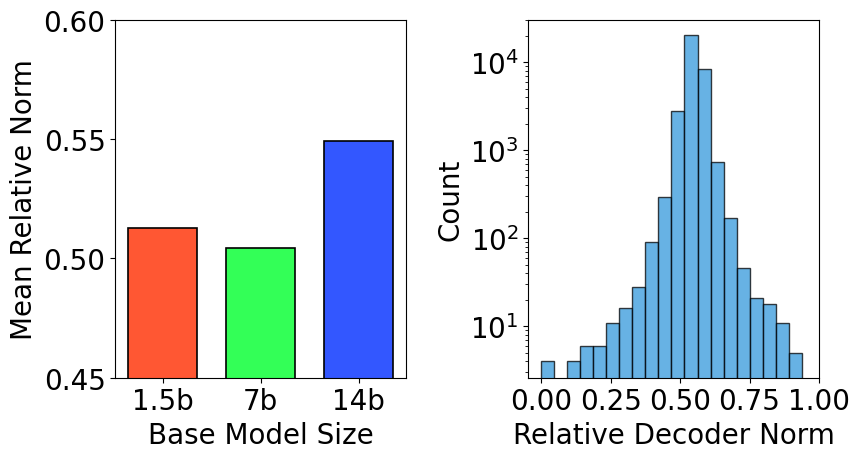

In [66]:
import torch

save_name = "qwen-14b"

save_name_to_idx_map = {
    "qwen-1.5b": 0,
    "qwen-7b": 1,
    "qwen-14b": 2,
}

name_to_model_map = {
    "qwen-1.5b": ["Qwen/Qwen2.5-Math-1.5B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"],
    "qwen-7b": ["Qwen/Qwen2.5-Math-7B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"],
    "qwen-14b": ["Qwen/Qwen2.5-14B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B"],
}

weight_path = f"./checkpoints/version_{save_name_to_idx_map[save_name]}/{save_name}_6.pt"
weights = torch.load(weight_path, map_location="cpu")
print(weights.keys())

base_dec = weights["W_dec"][:, 0, :]
reasoning_dec = weights["W_dec"][:, 1, :]
print(base_dec.shape, reasoning_dec.shape)
base_norms = torch.norm(base_dec, p=1, dim=1)
reasoning_norms = torch.norm(reasoning_dec, p=1, dim=1)

relative_norms = reasoning_norms.float() / base_norms.float()
normalized_relative_norms = relative_norms / (1 + relative_norms)

data_list = [0.5127, 0.5042, 0.5494]
labels = ["1.5b", "7b", "14b"]

import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20
plt.figure(figsize=(9, 5))

plt.subplot(1, 2, 2)
plt.hist(normalized_relative_norms.numpy(), bins=20, color='#3498db', edgecolor='black', alpha=0.75)
#print(normalized_relative_norms.mean(), normalized_relative_norms.std())
plt.ylabel('Count')
plt.xlabel('Relative Decoder Norm')
plt.yticks([0,5000,10000,15000,20000])
plt.xticks([0,0.25,0.5,0.75,1])
plt.yscale('log')
plt.ylim(0, 30000)

plt.subplot(1, 2, 1)
colors = ['#FF5733', '#33FF57', '#3357FF']  # Different colors for each bar
plt.bar(labels, data_list, width=0.7,color=colors, edgecolor='black', linewidth=1.2)
plt.ylim(0.45, 0.6)  # Set the y-axis limits
plt.yticks([0.45, 0.5, 0.55, 0.6])  # Set the y-axis ticks

# Add labels and title with a more stylish font
plt.xlabel("Base Model Size")
plt.ylabel("Mean Relative Norm")

plt.tight_layout()
plt.savefig("./figures/relative_norms.pdf", bbox_inches='tight')


/tmp/ipykernel_3859784/2147920510.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(weight_path, map_location="cpu")


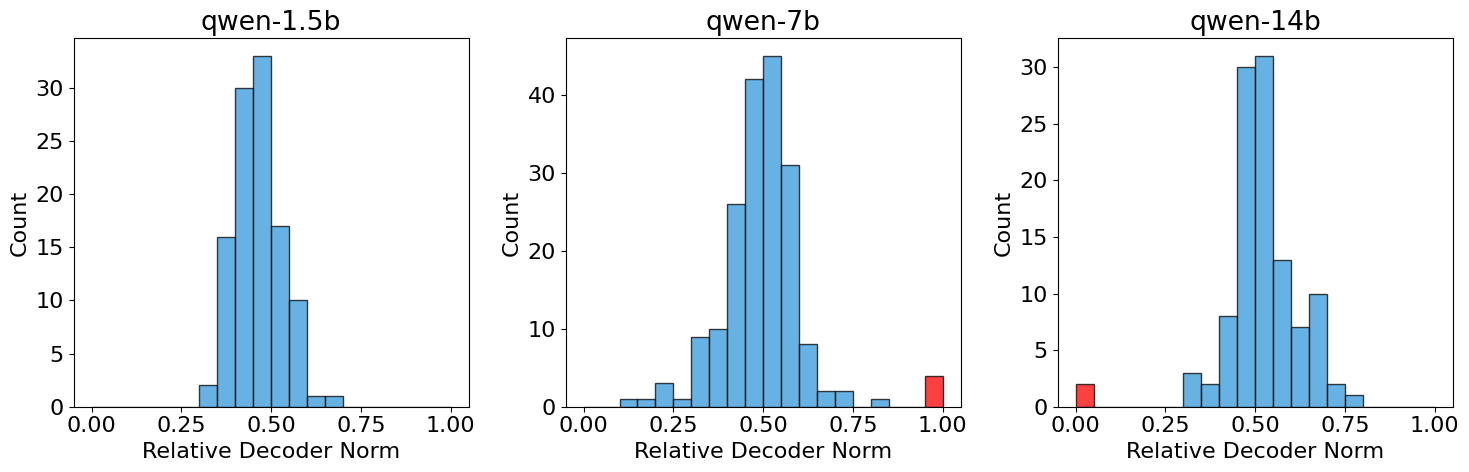

In [60]:
import torch

plt.figure(figsize=(15, 5))

save_name_to_idx_map = {
    "qwen-1.5b": 0,
    "qwen-7b": 1,
    "qwen-14b": 2,
}

name_to_model_map = {
    "qwen-1.5b": ["Qwen/Qwen2.5-Math-1.5B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"],
    "qwen-7b": ["Qwen/Qwen2.5-Math-7B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"],
    "qwen-14b": ["Qwen/Qwen2.5-14B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B"],
}
save_name_list = ["qwen-1.5b", "qwen-7b", "qwen-14b"]
for i in range(3):
    save_name = save_name_list[i]
    weight_path = f"./checkpoints/version_{save_name_to_idx_map[save_name]}/{save_name}_6.pt"
    weights = torch.load(weight_path, map_location="cpu")

    base_dec = weights["W_dec"][:, 0, :]
    reasoning_dec = weights["W_dec"][:, 1, :]
    
    base_norms = torch.norm(base_dec, p=1, dim=1)
    reasoning_norms = torch.norm(reasoning_dec, p=1, dim=1)

    new_filename = "./results/" + weight_path[2:-3].replace("/","__") + "_wait.json"

    import json
    with open(new_filename, 'r') as f:
        data = json.load(f)
        
    new_data = []
    for key in data.keys():
        if data[key] > 3000:
            rel_norm = reasoning_norms[int(key)] / base_norms[int(key)]
            normalized_relative_norms = rel_norm / (1 + rel_norm)
            new_data.append(normalized_relative_norms.item())

    plt.subplot(1, 3, i+1)
    hist_values, bin_edges, patches = plt.hist(new_data, bins=20, range=(0,1), color='#3498db', edgecolor='black', alpha=0.75)
    extreme_bin_index = -1  # Last bin (rightmost)
    if i== 2:
        extreme_bin_index = 0
    patches[extreme_bin_index].set_facecolor('red')  # Change color to red
    plt.title(f"{save_name}")
    plt.xlabel('Relative Decoder Norm')
    plt.ylabel('Count')

plt.tight_layout()
plt.savefig("./figures/wait_plot.pdf", bbox_inches='tight')
    

In [ ]:
import torch

plt.figure(figsize=(15, 5))

save_name_to_idx_map = {
    "qwen-1.5b": 0,
    "qwen-7b": 1,
    "qwen-14b": 2,
}

target_name_list = ["wait", "deductive", "alternative", "contrastive"]

target_token_map = {
    "wait" : [" wait", "Wait"],
    "deductive": ["Therefore", "Thus"],
    "alternative": ["Alternatively"],
    "contrastive": ["However", "But"]
}


target_token_count = {
    "wait": 3605,
    "deductive": 3605,
    "alternative":
    "contrastive"
}

name_to_model_map = {
    "qwen-1.5b": ["Qwen/Qwen2.5-Math-1.5B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"],
    "qwen-7b": ["Qwen/Qwen2.5-Math-7B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"],
    "qwen-14b": ["Qwen/Qwen2.5-14B", "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B"],
}
for i in range(4):
    save_name = "qwen-7b"
    target_name = target_name_list[i]
    weight_path = f"./checkpoints/version_{save_name_to_idx_map[save_name]}/{save_name}_6.pt"
    weights = torch.load(weight_path, map_location="cpu")

    base_dec = weights["W_dec"][:, 0, :]
    reasoning_dec = weights["W_dec"][:, 1, :]
    
    base_norms = torch.norm(base_dec, p=1, dim=1)
    reasoning_norms = torch.norm(reasoning_dec, p=1, dim=1)

    new_filename = "./results/" + weight_path[2:-3].replace("/","__") + f"_{target_name}.json"

    import json
    with open(new_filename, 'r') as f:
        data = json.load(f)
        
    new_data = []
    for key in data.keys():
        if data[key] > target_token_count[target_name] * 0.6:
            rel_norm = reasoning_norms[int(key)] / base_norms[int(key)]
            normalized_relative_norms = rel_norm / (1 + rel_norm)
            new_data.append(normalized_relative_norms.item())

    plt.subplot(1, 4, i+1)
    hist_values, bin_edges, patches = plt.hist(new_data, bins=20, range=(0,1), color='#3498db', edgecolor='black', alpha=0.75)
    extreme_bin_index = -1  # Last bin (rightmost)
    if i== 2:
        extreme_bin_index = 0
    patches[extreme_bin_index].set_facecolor('red')  # Change color to red
    plt.title(f"{save_name}")
    plt.xlabel('Relative Decoder Norm')
    plt.ylabel('Count')

plt.tight_layout()
plt.savefig("./figures/reasoning_plot.pdf", bbox_inches='tight')
    